In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout

Using TensorFlow backend.


In [4]:
from sklearn.preprocessing import StandardScaler
from keras import metrics

In [5]:
# train = pd.read_csv('wrangled_data/training_post_wrangle_small.csv')

test_full = pd.read_csv('wrangled_data/testing_post_wrangle_small.csv')

test_final = test_full.loc[:,['ID', 'shop_id', 'item_id']]

In [6]:
train = pd.read_csv('./csv_folder/sales_train.csv')
train = train.pivot_table(index = ['shop_id','item_id'],
                     values = ['item_cnt_day'],
                     columns = ['date_block_num'],
                     fill_value = 0,
                     aggfunc='sum')
train.head()

item_cnt_day                              ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28   
shop_id item_id                                           ...                  
0       30                 0  31  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0  ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  

[5 rows x 34 columns]

In [7]:
train = train.stack().rename(columns={'item_cnt_day':'item_cnt_month'}).unstack().reset_index()

In [8]:
train = pd.merge(test_final, train, on = ['item_id','shop_id'], how='left')

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [9]:
train = train.drop(columns=['ID', 'shop_id', 'item_id']).fillna(0)

In [10]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

In [11]:
X_train = train_scaled[:,:-1]
X_predict = train_scaled[:,1:]
y_train = train_scaled[:,-1]

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 33) (214200,) (214200, 33)


In [12]:
X_train = X_train.reshape((214200, -1, 33))
X_predict = X_predict.reshape((214200, -1, 33))
y_train = y_train.reshape((214200, -1))

print(X_train.shape, y_train.shape, X_predict.shape)

(214200, 1, 33) (214200, 1) (214200, 1, 33)


In [ ]:
# dir(metrics)

In [161]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(128, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model_lstm.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True))
model_lstm.add(tf.keras.layers.LeakyReLU(alpha=0.3))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.LSTM(64, return_sequences=False))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.Dense(1))

from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
# def 
# loss = tf.square(Y - Y_predicted, name='loss')

model_lstm.compile(loss = root_mean_squared_error,  # 'mean_squared_logarithmic_error', binary_crossentropy
                   optimizer = 'RMSprop',  # 'Nadam', 'adam', 'RMSprop', 'Ftrl', 'Adamax', 'Adagrad', 'Adadelta', 'SGD'
                   metrics = ['accuracy'])  # 'mean_tensor', 'kullback_leibler_divergence', 'mean_squared_error', 'mean_absolute_error', 'logcosh', 'cosine_proximity', 'cosine_similarity'
model_lstm.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_183 (LSTM)              (None, 1, 128)            82944     
_________________________________________________________________
leaky_re_lu_122 (LeakyReLU)  (None, 1, 128)            0         
_________________________________________________________________
lstm_184 (LSTM)              (None, 1, 128)            131584    
_________________________________________________________________
leaky_re_lu_123 (LeakyReLU)  (None, 1, 128)            0         
_________________________________________________________________
dropout_122 (Dropout)        (None, 1, 128)            0         
_________________________________________________________________
lstm_185 (LSTM)              (None, 64)                49408     
_________________________________________________________________
dropout_123 (Dropout)        (None, 64)              

In [168]:
history_lstm = model_lstm.fit(X_train, y_train, batch_size = None, epochs = 1)

Train on 214200 samples
214200/214200 [==============================] - 210s 980us/sample - loss: 0.1632 - accuracy: 0.0000e+00


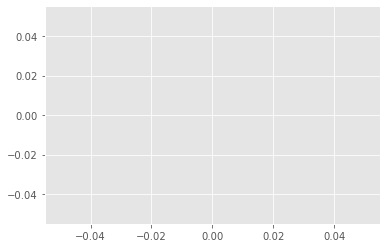

In [169]:
plt.plot(history_lstm.history['accuracy'], color='g', label='Accuracy')
# plt.plot(history_lstm.history['mean_squared_logarithmic_error'], color='r', label='mean_squared_logarithmic_error')
# plt.plot(history_lstm.history['MeanAbsoluteError'], color='b', label='MeanAbsoluteError')

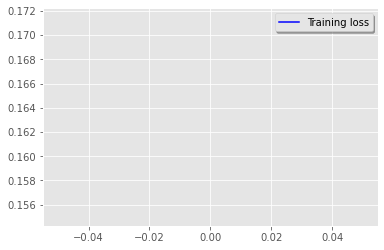

In [170]:
# Plot the loss curves for training
plt.plot(history_lstm.history['loss'], color='b', label="Training loss")
plt.legend(loc='best', shadow=True)

In [171]:
# creating submission file 
submission_pfs = model_lstm.predict(X_predict)

In [172]:
submit_scaled = np.hstack((X_predict.reshape(214200, 33), submission_pfs))

In [173]:
submit = scaler.inverse_transform(submit_scaled)
submit.shape

(214200, 34)

In [174]:
# we will keep every value between 0 and 20
submit = submit.clip(0,20)

In [175]:
# creating dataframe with required columns 
submit = pd.DataFrame({'ID':test_final['ID'],'item_cnt_month':submit[:,-1].ravel()})
# creating csv file from dataframe
submit.to_csv('submission_files/fresh_start.csv',index = False)

In [176]:
submit.shape, test_final.shape

((214200, 2), (214200, 3))

In [177]:
submit.head(3)

,ID,item_cnt_month
0,0,0.483109
1,1,0.070834
2,2,0.688557
